In [9]:
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import GroupKFold, train_test_split
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    mean_absolute_percentage_error,)

import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

# Cleaned version

In [2]:
DATA_DIR   = Path("../data/df_clean")
YEARS      = range(2010, 2023)
N_CLUSTERS = 10
SVI_EPOCHS = 2000
LR         = 1e-2
SHOW_MAPS  = True
SEED       = 42
pyro.set_rng_seed(SEED); np.random.seed(SEED)

# COLUMN MAP & FEATURES 
CENSUS_MAP = {
    "E_TOTPOP": "Total Population",
    "E_UNEMP": "Estimated Unemployed",
    "E_LIMENG": "Estimated Limited English Proficiency",
    "E_NOVEH": "Estimated No Vehicle",
    "E_HU": "Estimated Housing Units",
    "E_MOBILE": "Estimated Mobile Homes",
    "E_CROWD": "Estimated Crowded Housing",
    "B19001_001E": "Household Income Distribution",
    "B19013_001E": "Median Household Income",
    "LAT": "Latitude",
    "LON": "Longitude",
    "DAMAGE_PROPERTY": "Damage to Property",
}
FEATURES = ["log_pop", "log_medinc", "pct_unemp", "pct_mobile", "pct_crowd"]
TARGET   = "Damage to Property"


def load_all_years(data_dir: Path, years):
    dfs = []
    for y in years:
        fp = data_dir / f"df_hurricane_{y}.csv"
        if fp.exists():
            df = pd.read_csv(fp).rename(columns=CENSUS_MAP)
            df["Year"] = y
            dfs.append(df)
    if not dfs:
        raise FileNotFoundError("No yearly CSVs found – check DATA_DIR")
    return pd.concat(dfs, ignore_index=True)


def add_features(df):
    eps = 1e-6
    df["pct_unemp"]  = df["Estimated Unemployed"] / (df["Total Population"] + eps)
    df["pct_mobile"] = df["Estimated Mobile Homes"] / (df["Estimated Housing Units"] + eps)
    df["pct_crowd"]  = df["Estimated Crowded Housing"] / (df["Estimated Housing Units"] + eps)
    df["log_pop"]    = np.log1p(df["Total Population"].clip(lower=0))
    df["log_medinc"] = np.log1p(df["Median Household Income"].clip(lower=0))
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    needed = FEATURES + ["Latitude", "Longitude", TARGET]
    return df.dropna(subset=needed).reset_index(drop=True)

In [3]:
# Clustering and plotting the clusters on CONUS

def add_spatial_clusters(df, n_clusters=N_CLUSTERS):
    km = KMeans(n_clusters=n_clusters, random_state=SEED)
    df["cluster"] = km.fit_predict(df[["Latitude", "Longitude"]])
    return df, km


def plot_conus_clusters(df, held=None, title="Clusters"):
    proj = ccrs.Mercator()
    ax = plt.axes(projection=proj)
    ax.set_extent([-125, -66, 24, 50], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.STATES, linewidth=.4)
    ax.add_feature(cfeature.COASTLINE, linewidth=.5)
    ax.scatter(df["Longitude"], df["Latitude"], c=df["cluster"], cmap="tab10",
               s=12, transform=ccrs.PlateCarree(), alpha=.7)
    if held is not None:
        mask = df["cluster"] == held
        ax.scatter(df.loc[mask, "Longitude"], df.loc[mask, "Latitude"],
                   facecolors='none', edgecolors='k', s=40,
                   transform=ccrs.PlateCarree(), label="Held‑out")
        ax.legend()
    plt.title(title); plt.show()

# Preparing tensors and standardizing them

def tensors_from_df(df, scaler=None):
    X = df[FEATURES].to_numpy()
    y = np.log1p(df[TARGET].values)
    scaler = StandardScaler().fit(X) if scaler is None else scaler
    return torch.tensor(scaler.transform(X), dtype=torch.float32), torch.tensor(y, dtype=torch.float32), scaler


In [4]:
# Pipeline

def model(X, y=None):
    n = X.shape[1]
    beta  = pyro.sample("beta", dist.Normal(torch.zeros(n), 10.).to_event(1))
    alpha = pyro.sample("alpha", dist.Normal(0., 10.))
    sigma = pyro.sample("sigma", dist.HalfNormal(10.))
    mu = alpha + (X * beta).sum(-1)
    with pyro.plate("obs", X.size(0)):
        pyro.sample("y", dist.Normal(mu, sigma), obs=y)


def guide(X, y=None):
    n = X.shape[1]
    beta_loc   = pyro.param("beta_loc", torch.zeros(n))
    beta_scale = pyro.param("beta_scale", torch.ones(n), constraint=dist.constraints.positive)
    alpha_loc  = pyro.param("alpha_loc", torch.tensor(0.))
    alpha_scale= pyro.param("alpha_scale", torch.tensor(1.), constraint=dist.constraints.positive)
    sigma_loc  = pyro.param("sigma_loc", torch.tensor(1.), constraint=dist.constraints.positive)

    pyro.sample("beta",  dist.Normal(beta_loc, beta_scale).to_event(1))
    pyro.sample("alpha", dist.Normal(alpha_loc, alpha_scale))
    pyro.sample("sigma", dist.HalfNormal(sigma_loc + 1e-3))

In [7]:
# Training, prediction and calculating evaluation metrics
def train_svi(Xtr, ytr, Xval=None, yval=None, epochs=SVI_EPOCHS):
    pyro.clear_param_store()
    svi = SVI(model, guide, Adam({"lr": LR}), loss=Trace_ELBO())
    tl, vl = [], []
    for _ in range(epochs):
        tl.append(svi.step(Xtr, ytr))
        if Xval is not None:
            with torch.no_grad():
                vl.append(svi.loss(model, guide, Xval, yval))
    return tl, vl


def predict(df, scaler):
    X, y_true, _ = tensors_from_df(df, scaler)
    with torch.no_grad():
        alpha = pyro.param("alpha_loc").item()
        beta  = pyro.param("beta_loc").detach().numpy()
        y_hat = alpha + (X.numpy() @ beta)
    return np.expm1(y_hat), np.expm1(y_true.numpy())


def compute_metrics(y_true, y_pred):
    return {
        "MAE":  mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAPE": mean_absolute_percentage_error(y_true, y_pred),
        "R2":   r2_score(y_true, y_pred),
    }

def plot_elbo(tr, val=None, title="ELBO"):
    plt.figure(figsize=(5,3))
    plt.plot(tr, label="train")
    if val: plt.plot(val, label="val")
    plt.xlabel("epoch"); plt.ylabel("ELBO (-loss)"); plt.title(title); plt.legend(); plt.tight_layout(); plt.show()


def plot_residuals(y_true, y_pred, title="Residuals"):
    res = y_pred - y_true
    plt.figure(figsize=(5,3))
    plt.scatter(y_true, res, alpha=.4)
    plt.axhline(0, color="r", ls="--")
    plt.xlabel("True"); plt.ylabel("Residual"); plt.title(title); plt.tight_layout(); plt.show()

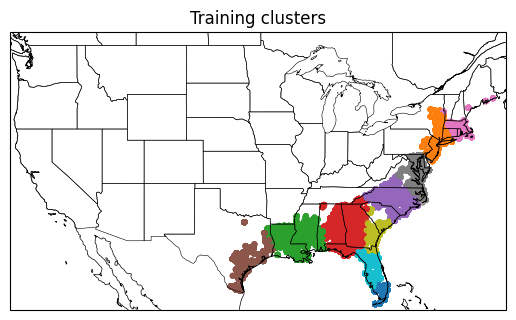

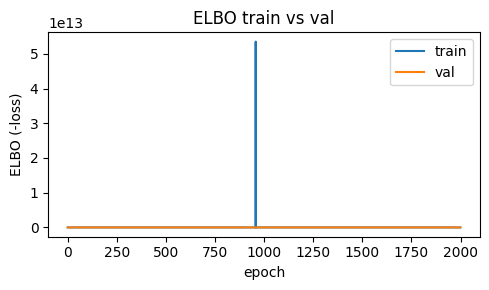

2022 hold‑out metrics → MAE=181,800,656.00, RMSE=986,288,991.44, MAPE=46,309,952,293,175,296.00, R2=-0.04


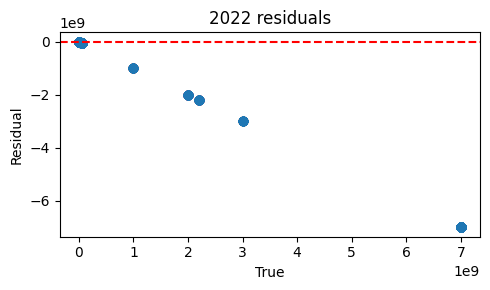

Fold 00 → MAE=4,433,492.00, RMSE=35,629,766.50, MAPE=1,624,544,536,166,400.00, R2=-0.02


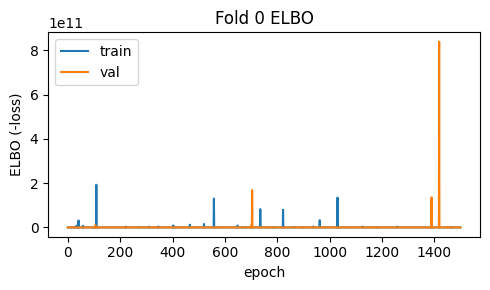

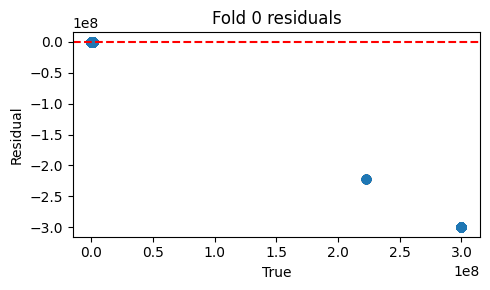

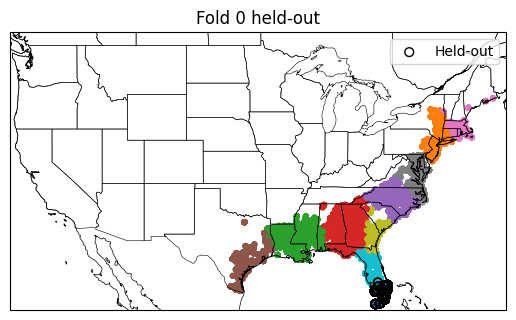

Fold 01 → MAE=1,281,907.62, RMSE=3,454,458.19, MAPE=2,171,416,011,079,680.00, R2=-0.16


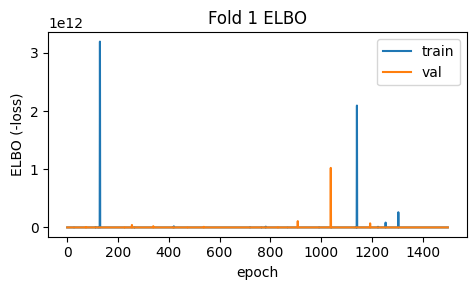

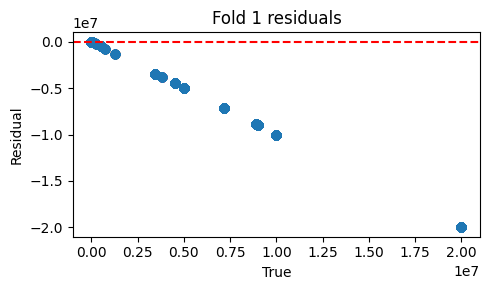

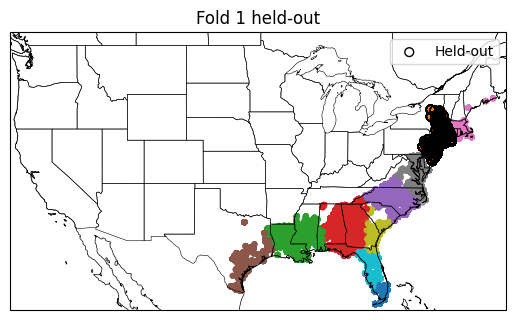

Fold 02 → MAE=24,711,798.00, RMSE=127,873,533.52, MAPE=20,674,995,457,884,160.00, R2=-0.04


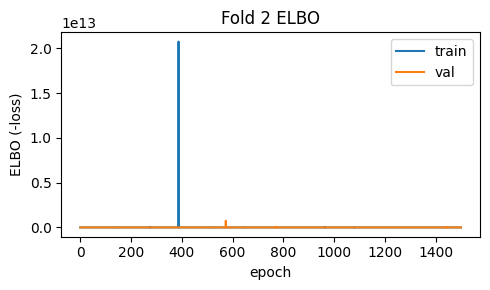

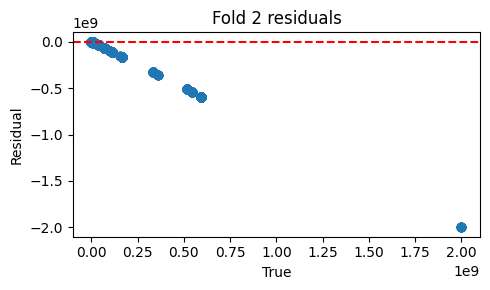

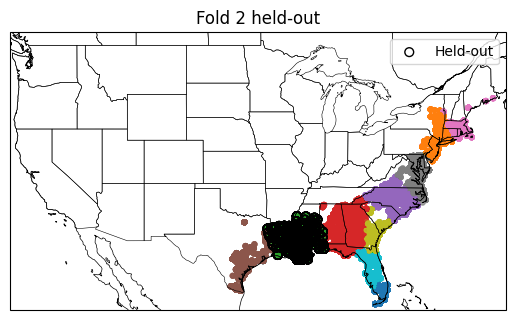

Fold 03 → MAE=586,244.25, RMSE=1,740,162.22, MAPE=2,118,148,350,279,680.00, R2=-0.13


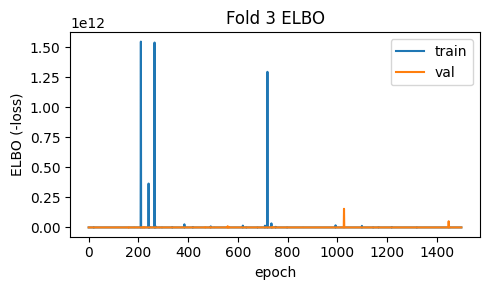

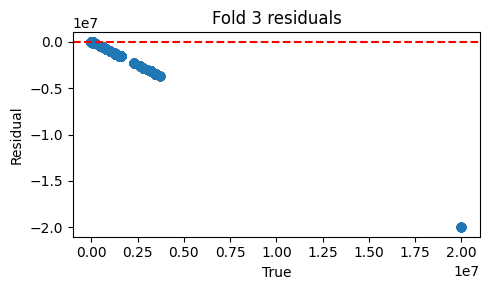

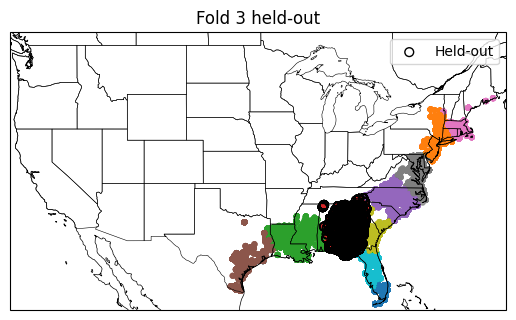

Fold 04 → MAE=332,869.91, RMSE=1,630,099.21, MAPE=203,881,341,626,875,904.00, R2=-0.04


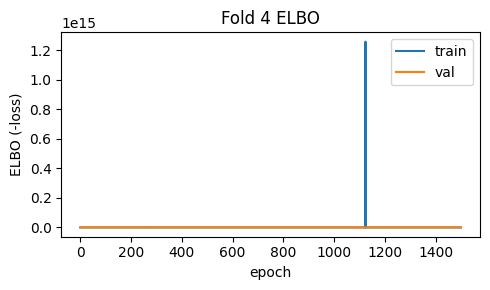

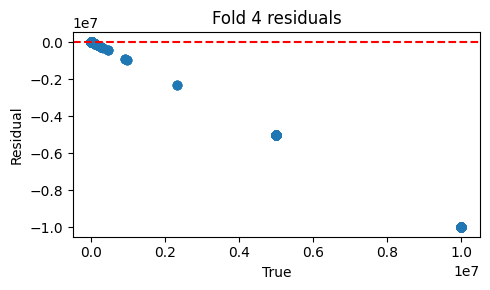

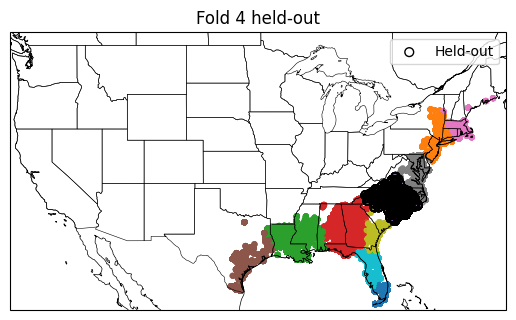

Fold 05 → MAE=39,756,100.00, RMSE=441,028,221.18, MAPE=1,823,720,354,573,451,264.00, R2=-0.01


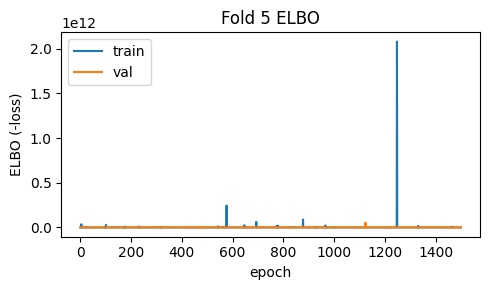

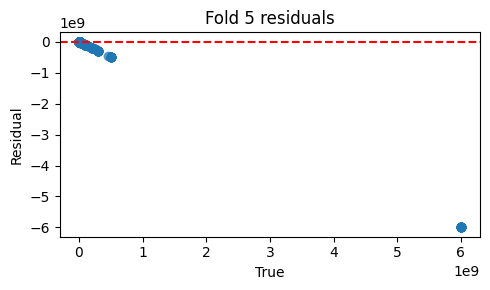

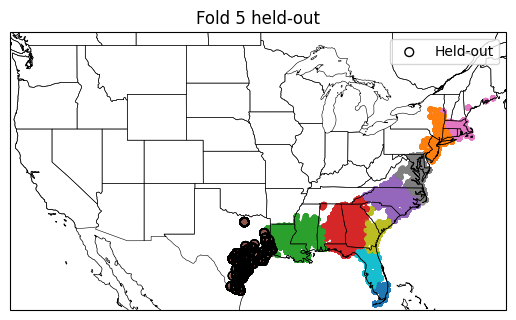

Fold 06 → MAE=393,817.47, RMSE=1,105,116.80, MAPE=244,770,890,573,676,544.00, R2=-0.15


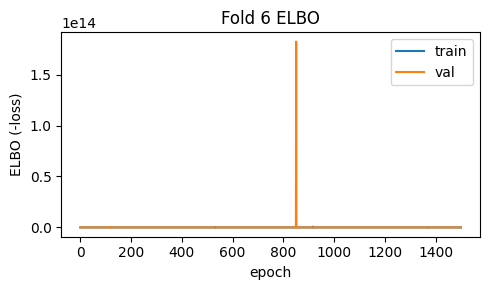

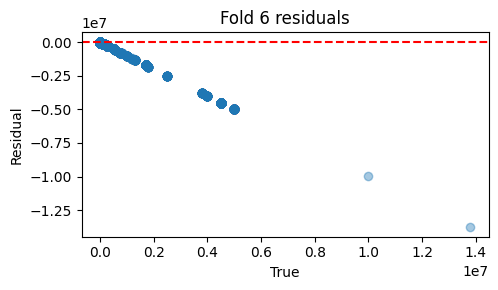

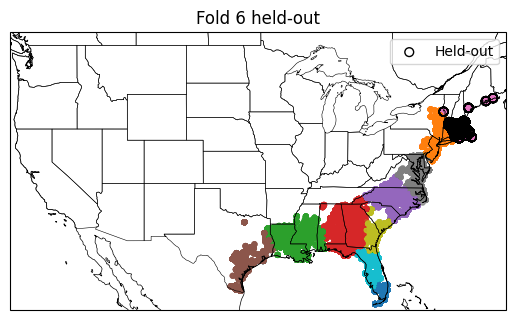

Fold 07 → MAE=7,482,251.00, RMSE=75,293,537.90, MAPE=8,624,195,546,120,192.00, R2=-0.01


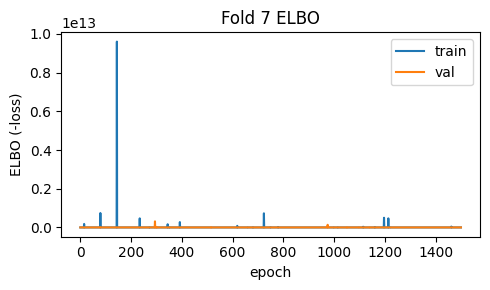

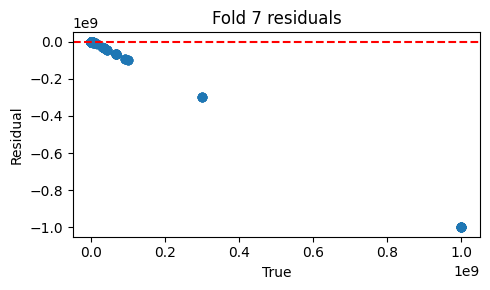

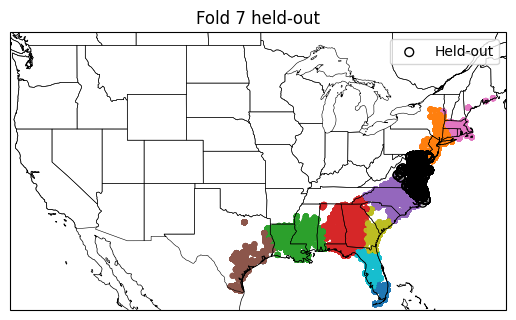

Fold 08 → MAE=72,577,184.00, RMSE=208,030,548.12, MAPE=1,155,368,885,420,032.00, R2=-0.14


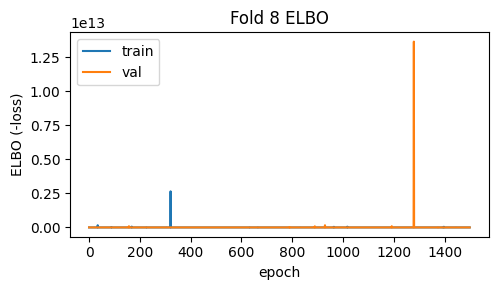

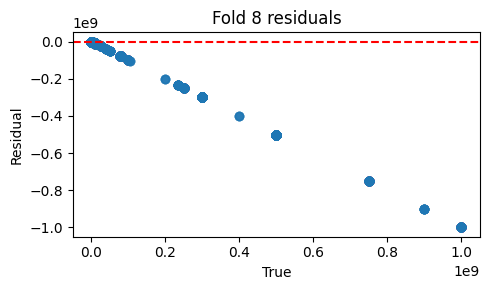

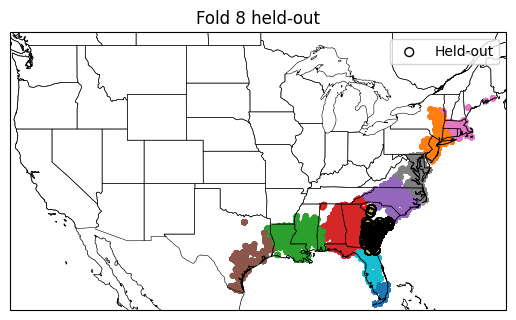

Fold 09 → MAE=55,577,292.00, RMSE=189,947,727.17, MAPE=444,429,190,037,504.00, R2=-0.09


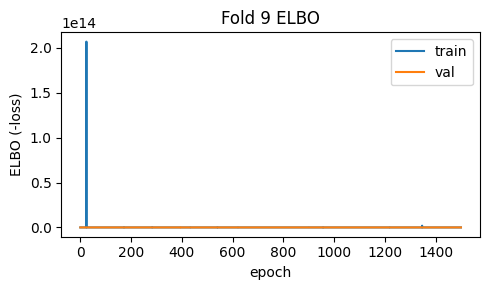

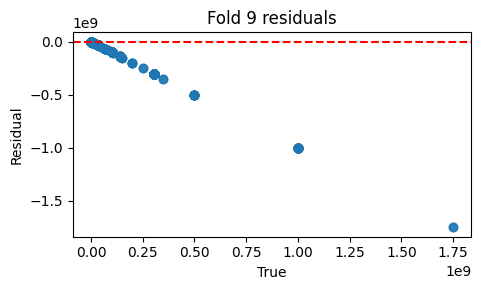

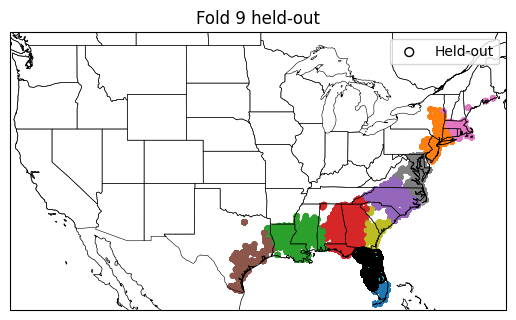

Cluster‑CV mean ± std → MAE=20,713,295.62±25,169,406.25, RMSE=108,573,317.08±133,899,277.71, MAPE=230,918,568,475,099,136.00±538,025,805,578,215,296.00, R2=-0.08±0.06


In [8]:
df_all = add_features(load_all_years(DATA_DIR, YEARS))
train_df = df_all[df_all["Year"] < 2022].copy()
test_df  = df_all[df_all["Year"] == 2022].copy()

train_df, km = add_spatial_clusters(train_df)
test_df["cluster"] = km.predict(test_df[["Latitude", "Longitude"]])
if SHOW_MAPS: plot_conus_clusters(train_df, title="Training clusters")

# Train/validation splitting
tr_df, val_df = train_test_split(train_df, test_size=.15, random_state=SEED)
Xtr, ytr, scaler = tensors_from_df(tr_df)
Xval, yval, _    = tensors_from_df(val_df, scaler)

tr_elbo, val_elbo = train_svi(Xtr, ytr, Xval, yval)
plot_elbo(tr_elbo, val_elbo, "ELBO train vs val")

# 2022 hold‑out
y_hat, y_true = predict(test_df, scaler)
test_metrics  = compute_metrics(y_true, y_hat)
print("2022 hold‑out metrics → " + ", ".join([f"{k}={v:,.2f}" for k,v in test_metrics.items()]))
plot_residuals(y_true, y_hat, "2022 residuals")

# Cluster‑wise Cross Validation (CV)
gkf = GroupKFold(n_splits=N_CLUSTERS)
cv_metrics = []  # list of dicts
for fold, (tri, vali) in enumerate(gkf.split(train_df, groups=train_df["cluster"])):
    Xc, yc, _ = tensors_from_df(train_df.iloc[tri], scaler=None)
    Xv, yv, _ = tensors_from_df(train_df.iloc[vali], scaler=None)
    # fresh fit per fold
    tr_l, val_l = train_svi(Xc, yc, Xv, yv, epochs=1500)
    # metrics on held cluster
    scaler_f = StandardScaler().fit(train_df.iloc[tri][FEATURES])
    yh, yt = predict(train_df.iloc[vali], scaler_f)
    m = compute_metrics(yt, yh)
    cv_metrics.append(m)
    print(f"Fold {fold:02d} → " + ", ".join([f"{k}={v:,.2f}" for k,v in m.items()]))
    plot_elbo(tr_l, val_l, f"Fold {fold} ELBO")
    plot_residuals(yt, yh, f"Fold {fold} residuals")
    if SHOW_MAPS:
        plot_conus_clusters(train_df, held=fold, title=f"Fold {fold} held‑out")

# Print CV summary 
summary = {k: (np.mean([d[k] for d in cv_metrics]), np.std([d[k] for d in cv_metrics])) for k in cv_metrics[0]}
print("Cluster‑CV mean ± std → " + ", ".join([f"{k}={mu:,.2f}±{sd:,.2f}" for k,(mu,sd) in summary.items()]))
